<a href="https://colab.research.google.com/github/demelere/Image-Classification/blob/master/458_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup

In [1]:
import numpy as np
import pandas as pd
import os
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Check versions
print(keras.__version__)
print(tf.__version__)

2.3.0-tf
2.2.0


In [3]:
tf.compat.v1.disable_eager_execution() 

In [4]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Data import and transformation

In [5]:
# Import data from Keras
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
# Check shapes
train_images.shape, test_images.shape, test_labels.shape, test_labels.shape

((60000, 28, 28), (10000, 28, 28), (10000,), (10000,))

In [7]:
# Reshape into arrays
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

In [8]:
# Create training set
val_images, train_images = train_images[:5000], train_images[5000:] 
val_labels, train_labels = train_labels[:5000], train_labels[5000:]

# 1. Experiment 1

## 1a.  Build and Compile Model

In [9]:
# Define model using Sequential class
# 2 Dense layers: hidden layer w/1 node, 2nd layer 10-way softmax layer
# reLu activation
model_1 = models.Sequential()
model_1.add(layers.Dense(1, activation='relu', input_shape=(28 * 28,)))
model_1.add(layers.Dense(10, activation='softmax')) 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
# Model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 785       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20        
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Compile model
# add loss function, optimizer, and performance metric
model_1.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## 1b. Train Model

In [16]:
# Train the model by calling fit method
start_time = time.time()
history = model_1.fit(train_images, train_labels, validation_data=(val_images, val_labels), 
                      epochs=30)

elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')


Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 2s 33us/sample - loss: 1.5341 - accuracy: 0.4049 - val_loss: 1.5307 - val_accuracy: 0.4158
Epoch 2/30
55000/55000 [==============================] - 2s 33us/sample - loss: 1.5343 - accuracy: 0.4073 - val_loss: 1.5314 - val_accuracy: 0.4194
Epoch 3/30
55000/55000 [==============================] - 2s 32us/sample - loss: 1.5338 - accuracy: 0.4083 - val_loss: 1.5336 - val_accuracy: 0.4210
Epoch 4/30
55000/55000 [==============================] - 2s 32us/sample - loss: 1.5343 - accuracy: 0.4077 - val_loss: 1.5321 - val_accuracy: 0.4184
Epoch 5/30
55000/55000 [==============================] - 2s 33us/sample - loss: 1.5339 - accuracy: 0.4045 - val_loss: 1.5356 - val_accuracy: 0.4182
Epoch 6/30
55000/55000 [==============================] - 2s 33us/sample - loss: 1.5339 - accuracy: 0.4047 - val_loss: 1.5328 - val_accuracy: 0.4166
Epoch 7/30
55000/55000 [==============================] -

## 1c. Test model

In [17]:
test_loss, test_acc = model_1.evaluate(test_images, test_labels)

In [18]:
print(f'test accuracy: {test_acc}, test loss: {test_loss}')

test accuracy: 0.40790000557899475, test loss: 1.5781789979934693


In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

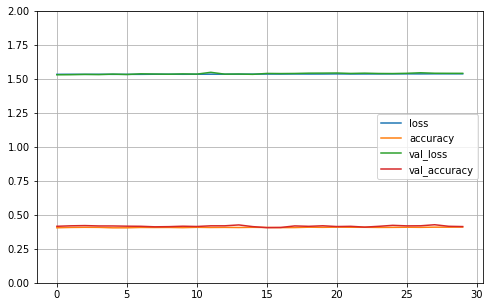

In [22]:
# Alternate code for accuracy and loss
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.show()

## 1d. Confusion matrix

In [26]:
# Assign predicted classes
pred_classes = model_1.predict_classes(train_images)

In [27]:
# Create confusion matrix with values
conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[ 377,  479,  560,   44,    3,    0, 3936,    0,   44,    1],
       [  22, 5061,  124,  534,   41,   15,  123,    1,  258,    0],
       [ 262,  917,  624,  139,   58,    9, 3367,    2,   88,    4],
       [  35, 2039,  180, 1288,  434,  111,  393,   28, 1095,   35],
       [   5,  113,   22,   99, 3986,  132,   34,   48,  331,  537],
       [  28, 1198,  125,  958,  736,  202,  171,   47, 1484,   38],
       [  84,  193,  159,   22,    1,    2, 4942,    0,   14,    0],
       [   1,   74,   10,   67, 1373,   70,    4, 3614,  207,  295],
       [  11, 1613,   84, 1315,  629,  175,   59,   10, 1481,   12],
       [   5,   46,   12,   52, 2801,   59,    5, 1526,  142,  806]])

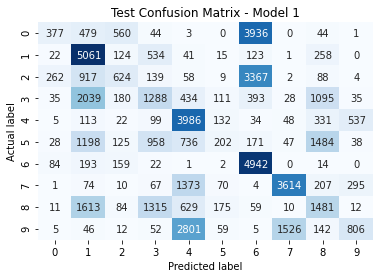

In [28]:
# Plot with values transposed to show actual versus predicted values
# m1_cm = confusion_matrix(train_labels, pred_classes)
m1_cm_plt=sns.heatmap(conf_mx, square=False, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title("Test Confusion Matrix - Model 1")
plt.show();

In [29]:
# Plot normalized confusion matrix
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

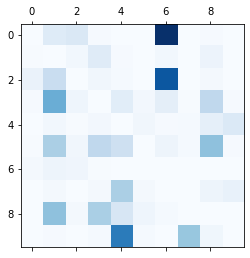

In [30]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap="Blues")
plt.show()

## 1e. Analyze Errors and Misclassifications

In [31]:
# Define function for plotting example digits
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = 'binary', **options)
    plt.axis("off")

 ## 1f.  Analyze Activation Values

In [33]:
# Activation values of the hidden nodes
# Extract the outputs of the 2 layers
layer_outputs = [layer.output for layer in model_1.layers]

# Create a model that will return these outputs, given the model input
activation_model_1 = models.Model(inputs=model_1.input, outputs=layer_outputs)

# Print a description of the layers
print(f"There are {len(layer_outputs)} layers")
layer_outputs

There are 2 layers


[<tf.Tensor 'dense/Relu:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'dense_1/Softmax:0' shape=(None, 10) dtype=float32>]

In [34]:
# Get the output of the hidden node for each of the 55000 training images
activations = activation_model_1.predict(train_images)
hidden_layer_activation = activations[0]
hidden_layer_activation.shape   #  hidden node has one activation value per training image

(55000, 1)

In [35]:
print(f"The maximum activation value of the hidden node is {hidden_layer_activation.max()}")

The maximum activation value of the hidden node is 92.77973175048828


In [36]:
# Output layer stats
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (55000, 10)
The output for the first image are [0.     0.     0.     0.     0.0024 0.     0.     0.8116 0.     0.1861]
The sum of the probabilities is (approximately) 0.9999999403953552


In [37]:
# Create DataFrame of activation values and corresponding predicted class
boxplot_df = pd.DataFrame({'act_value':hidden_layer_activation.reshape(55000),
                           'pred_class':pred_classes})
boxplot_df.head()

,act_value,pred_class
0,24.579069,7
1,2.897870,8
2,6.558838,9
3,0.000000,6
4,1.081513,1


In [38]:
# Value counts for boxplot
# Note missing class - 5
boxplot_df['pred_class'].value_counts() 

6    13034
1    11733
4    10062
7     5276
8     5144
3     4518
2     1900
9     1728
0      830
5      775
Name: pred_class, dtype: int64

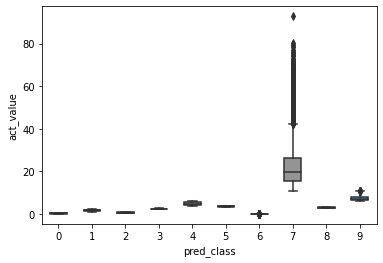

In [39]:
# Activation value boxplot
bplot = sns.boxplot(y='act_value', x='pred_class', 
                 data=boxplot_df, 
                 width=0.5,
                 palette="colorblind")
# bplot.savefig("act_values_model_1.png")

figure = bplot.get_figure()    
# figure.savefig("figures/act_values_model_1.png", dpi=400)
# ax.set(ylim=(10, 40))

# 2. Experiment 2


## 2a. Build and Compile Model

In [42]:
# 2 Dense layers
# Hidden layer, 2 nodes
# Second layer, 10-way softmax

# Define model
model_2 = models.Sequential()
model_2.add(layers.Dense(2, activation='relu', input_shape=(28 * 28,)))
model_2.add(layers.Dense(10, activation='softmax'))   

In [43]:
# Model summary
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 1570      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                30        
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Pick loss function, optimizer, and accuracy as a performance metric
# Compile the model
model_2.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## 3b. Train Model

In [45]:
# Train the model
start_time = time.time()
history = model_2.fit(train_images, train_labels, validation_data=(val_images, val_labels), 
                      epochs=30)
elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 2s 38us/sample - loss: 1.6658 - accuracy: 0.3666 - val_loss: 1.3717 - val_accuracy: 0.4414
Epoch 2/30
55000/55000 [==============================] - 2s 36us/sample - loss: 1.3222 - accuracy: 0.5012 - val_loss: 1.2407 - val_accuracy: 0.5418
Epoch 3/30
55000/55000 [==============================] - 2s 36us/sample - loss: 1.2332 - accuracy: 0.5566 - val_loss: 1.1774 - val_accuracy: 0.5898
Epoch 4/30
55000/55000 [==============================] - 2s 37us/sample - loss: 1.1851 - accuracy: 0.5894 - val_loss: 1.1373 - val_accuracy: 0.6214
Epoch 5/30
55000/55000 [==============================] - 2s 37us/sample - loss: 1.1509 - accuracy: 0.6084 - val_loss: 1.1171 - val_accuracy: 0.6346
Epoch 6/30
55000/55000 [==============================] - 2s 35us/sample - loss: 1.1262 - accuracy: 0.6184 - val_loss: 1.0947 - val_accuracy: 0.6406
Epoch 7/30
55000/55000 [==============================] -

## 2c. Test Model

Evaluate the model on the test dataset.

In [46]:
test_loss, test_acc = model_2.evaluate(test_images, test_labels)

In [47]:
print(f'test accuracy: {test_acc}, test loss: {test_loss}')

test accuracy: 0.6744999885559082, test loss: 1.0114024152755738


In [48]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

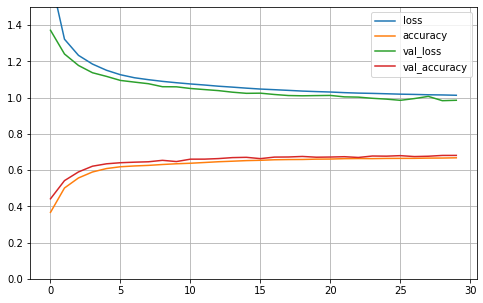

In [49]:
# Alternate code for accuracy and loss
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5) # set the vertical range to [0-1]
plt.show()

## 2d. Confusion Matrix

In [50]:
# Assign predicted classes
pred_classes = model_2.predict_classes(train_images)

In [51]:
# Create confusion matrix with values
conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[4122,  154,  873,   12,   19,    8,  136,    6,  112,    2],
       [  27, 5407,  120,  285,    3,  217,    1,   16,   98,    5],
       [ 970,  604, 2590,   29,   88,   81,  516,   17,  567,    8],
       [  22,  421,   88, 4178,    8,  436,    4,  258,  202,   21],
       [   4,    2,   32,    3, 3807,   12,  153,   56,  214, 1024],
       [  24,  212,  311,  755,   88, 1079,   60,  448, 1916,   94],
       [  98,    2,  349,    0,  314,    1, 4447,    0,  206,    0],
       [   3,   30,   34,  232,   54,   58,    3, 4288,  111,  902],
       [  13,  316,  314,  275,  388,  668,  133,  347, 2783,  152],
       [   4,    1,   23,   53,  321,   41,   37,  796,   96, 4082]])

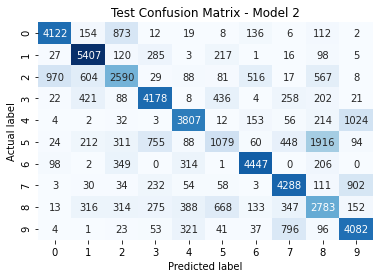

In [52]:
# Plot with values transposed to show actual versus predicted values
# m1_cm = confusion_matrix(train_labels, pred_classes)
m2_cm_plt=sns.heatmap(conf_mx, square=False, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title("Test Confusion Matrix - Model 2")
plt.show();

In [53]:
# Plot normalized confusion matrix
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

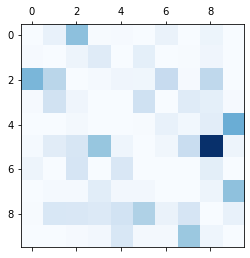

In [54]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap="Blues")
plt.show()

## 2e. Error Analysis

In [55]:
# Define function for plotting example digits
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = 'binary', **options)
    plt.axis("off")

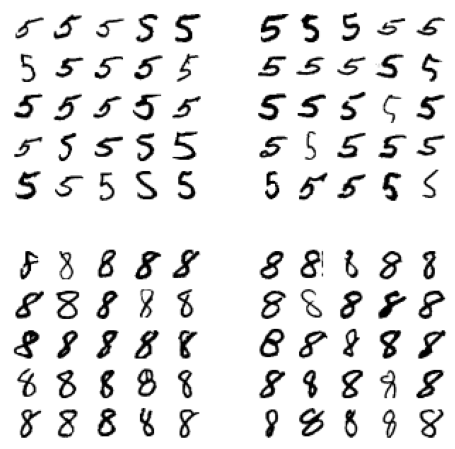

In [56]:
# Try some examples of mis-classes digits
# Upper left: 5s classified correctly as 5s
# Upper right: 5s classified as 8s
# Lower left: 8s classified as 5s
# Lower right: 8s classified correctly as 8s

cl_a, cl_b = 5, 8
X_aa = train_images[(train_labels == cl_a) & (pred_classes == cl_a)]
X_ab = train_images[(train_labels == cl_a) & (pred_classes == cl_b)]
X_ba = train_images[(train_labels == cl_b) & (pred_classes == cl_a)]
X_bb = train_images[(train_labels == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## 2f. Activation Values


In [57]:
# Extract the outputs of the 2 layers
layer_outputs = [layer.output for layer in model_2.layers]

# Create a model that will return these outputs, given the model input
activation_model_2 = models.Model(inputs=model_2.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs # description of the layers

There are 2 layers


[<tf.Tensor 'dense_4/Relu:0' shape=(None, 2) dtype=float32>,
 <tf.Tensor 'dense_5/Softmax:0' shape=(None, 10) dtype=float32>]

In [58]:
# Get the output of the hidden node for each of the 55000 training images
activations = activation_model_2.predict(train_images)
hidden_layer_activation = activations[0]
hidden_layer_activation.shape   #  2 hidden node each has one activation value per training image

(55000, 2)

In [59]:
hidden_node1_activation = hidden_layer_activation[:,0] # get activation values of the first hidden node
hidden_node2_activation = hidden_layer_activation[:,1] # get activation values of the second hidden node

print(f"The maximum activation value of the first hidden node is {hidden_node1_activation.max()}")
print(f"The maximum activation value of the second hidden node is {hidden_node2_activation.max()}")

The maximum activation value of the first hidden node is 24.955793380737305
The maximum activation value of the second hidden node is 19.6727294921875


In [60]:
# Output layer stats
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (55000, 10)
The output for the first image are [0.     0.     0.     0.0004 0.1119 0.0089 0.     0.2731 0.0098 0.5959]
The sum of the probabilities is (approximately) 0.9999999403953552


In [61]:
scatterPlot_df =  pd.DataFrame({'act_value_h1':hidden_node1_activation,
                                'act_value_h2':hidden_node2_activation,
                                'pred_class':pred_classes})
scatterPlot_df.head()

,act_value_h1,act_value_h2,pred_class
0,5.411855,0.000000,9
1,0.000000,0.080263,3
2,6.210288,0.000000,9
3,9.224747,7.711204,6
4,0.000000,2.918810,1


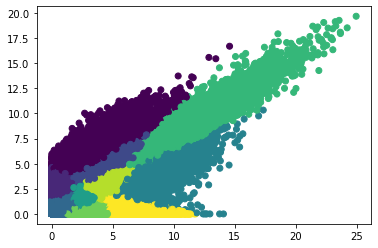

In [62]:
# plt.legend(loc='upper left', prop={'size':6}, bbox_to_anchor=(1,1),ncol=1)
plt.scatter(scatterPlot_df.act_value_h1, 
            scatterPlot_df.act_value_h2, 
            c=scatterPlot_df.pred_class,
            label=scatterPlot_df.pred_class)

plt.show()

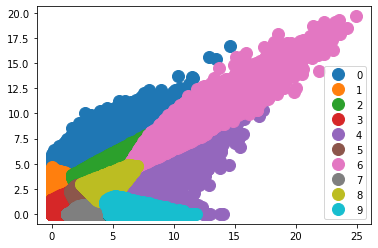

In [63]:
# Scatterplot grouped by predicted class
groups = scatterPlot_df.groupby('pred_class')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.act_value_h1, group.act_value_h2, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

# 3. Experiment 3

In [64]:
# 1 hidden layer
# Use gridsearch to determine the # of nodes

# Define a function to create a DNN with a given number of hidden layers and a fixed given number 
# of nodes per hidden layer
def build_model(n_hidden=1, n_neurons=2, learning_rate=0.001, input_shape=(28 * 28,)):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.RMSprop(lr=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
    return model

In [65]:
# Define a second model that takes a tuple `(n1,n2...)`, where the number of coordinates is the 
# number of `hidden layers` with `n1` nodes in the first hidden layer, `n2` nodes in the second, etc.
def build_model2(n_neurons=(2,3), learning_rate=0.001, input_shape=(28 * 28,)):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    for layer in range(len(n_neurons)):
        model.add(keras.layers.Dense(n_neurons[layer], activation="relu"))
    model.add(layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.RMSprop(lr=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
    return model

In [66]:
# Create a `KerasClassifier` object, the class is an implementation of the scikit-learn classifier API for Keras. 
# It is actually a thin wrapper around the model that is built using our `build_model` function.
keras_clf = KerasClassifier(build_model)

## 3a. Hyperparameter Tuning: # Nodes

```python
param_grid = {'n_neurons': range(100,900,50)}
param_grid
```

In [67]:
param_grid = {'n_neurons': range(100,900,50)}
param_grid

{'n_neurons': range(100, 900, 50)}

In [68]:
# Run grid search
grid_cv = GridSearchCV(estimator=keras_clf, param_grid=param_grid,cv=3,verbose = 2)
grid_cv.fit(train_images, train_labels, epochs=30,
                  validation_data=(val_images, val_labels),
                  callbacks=[keras.callbacks.EarlyStopping(patience=2)])

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] n_neurons=100 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 36666 samples, validate on 5000 samples
Epoch 1/30
36666/36666 [==============================] - 2s 64us/sample - loss: 0.3282 - accuracy: 0.9064 - val_loss: 0.1793 - val_accuracy: 0.9508
Epoch 2/30
36666/36666 [==============================] - 2s 64us/sample - loss: 0.1641 - accuracy: 0.9514 - val_loss: 0.1522 - val_accuracy: 0.9574
Epoch 3/30
36666/36666 [==============================] - 2s 65us/sample - loss: 0.1217 - accuracy: 0.9653 - val_loss: 0.1308 - val_accuracy: 0.9610
Epoch 4/30
36666/36666 [==============================] - 2s 66us/sample - loss: 0.0958 - accuracy: 0.9716 - val_loss: 0.1195 - val_accuracy: 0.9644
Epoch 5/30
36666/36666 [==============================] - 2s 63us/sample - loss: 0.0798 - accuracy: 0.9769 - val_loss: 0.1086 - val_accuracy: 0.9702
Epoch 6/30
36666/36666 [==============================] - 2s 63us/sample - loss: 0.0665 - accuracy: 0.9810 - val_loss: 0.1208 - val_accuracy: 0.9666
Epoch 7/30
36666/36666 [==============================] -

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.0s remaining:    0.0s


Train on 36667 samples, validate on 5000 samples
Epoch 1/30
36667/36667 [==============================] - 2s 66us/sample - loss: 0.3192 - accuracy: 0.9104 - val_loss: 0.1720 - val_accuracy: 0.9506
Epoch 2/30
36667/36667 [==============================] - 2s 63us/sample - loss: 0.1566 - accuracy: 0.9553 - val_loss: 0.1327 - val_accuracy: 0.9622
Epoch 3/30
36667/36667 [==============================] - 2s 63us/sample - loss: 0.1148 - accuracy: 0.9669 - val_loss: 0.1339 - val_accuracy: 0.9600
Epoch 4/30
36667/36667 [==============================] - 2s 65us/sample - loss: 0.0901 - accuracy: 0.9737 - val_loss: 0.1078 - val_accuracy: 0.9684
Epoch 5/30
36667/36667 [==============================] - 2s 64us/sample - loss: 0.0738 - accuracy: 0.9785 - val_loss: 0.0977 - val_accuracy: 0.9722
Epoch 6/30
36667/36667 [==============================] - 2s 64us/sample - loss: 0.0619 - accuracy: 0.9819 - val_loss: 0.1051 - val_accuracy: 0.9698
Epoch 7/30
36667/36667 [==============================] -

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 31.3min finished


Epoch 1/30
55000/55000 [==============================] - 13s 228us/sample - loss: 0.2056 - accuracy: 0.9390 - val_loss: 0.1074 - val_accuracy: 0.9670
Epoch 2/30
55000/55000 [==============================] - 12s 218us/sample - loss: 0.0911 - accuracy: 0.9737 - val_loss: 0.0916 - val_accuracy: 0.9766
Epoch 3/30
55000/55000 [==============================] - 13s 229us/sample - loss: 0.0653 - accuracy: 0.9817 - val_loss: 0.1072 - val_accuracy: 0.9714
Epoch 4/30
55000/55000 [==============================] - 13s 229us/sample - loss: 0.0496 - accuracy: 0.9865 - val_loss: 0.0918 - val_accuracy: 0.9748


GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f97d23b7278>,
             iid='deprecated', n_jobs=None,
             param_grid={'n_neurons': range(100, 900, 50)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [69]:
# Evaluate the number of neurons that produced the best estimator
grid_cv.best_params_

{'n_neurons': 700}

In [70]:
# Results to compare the performance of the models
results = grid_cv.cv_results_
results

{'mean_fit_time': array([18.45699437, 23.32269708, 24.91798735, 23.65983931, 28.39991379,
        27.21238597, 33.45330119, 35.24528098, 38.13743695, 39.36723463,
        42.23372785, 52.18744127, 59.99172322, 49.07264249, 56.16095734,
        59.81586027]),
 'mean_score_time': array([0.42550898, 0.47779671, 0.49913208, 0.58423694, 0.62343804,
        0.66136789, 0.8657035 , 0.86041768, 0.91568677, 0.95129633,
        1.01481485, 1.05562027, 1.14268438, 1.2235647 , 1.20471787,
        1.30116359]),
 'mean_test_score': array([0.96803631, 0.96994545, 0.97163639, 0.96952732, 0.97280004,
        0.97301823, 0.97383634, 0.972     , 0.97410909, 0.97167275,
        0.97309095, 0.97398184, 0.97487273, 0.97269092, 0.97110899,
        0.97349089]),
 'param_n_neurons': masked_array(data=[100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
                    650, 700, 750, 800, 850],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, F

In [71]:
results['params'], results['rank_test_score']

([{'n_neurons': 100},
  {'n_neurons': 150},
  {'n_neurons': 200},
  {'n_neurons': 250},
  {'n_neurons': 300},
  {'n_neurons': 350},
  {'n_neurons': 400},
  {'n_neurons': 450},
  {'n_neurons': 500},
  {'n_neurons': 550},
  {'n_neurons': 600},
  {'n_neurons': 650},
  {'n_neurons': 700},
  {'n_neurons': 750},
  {'n_neurons': 800},
  {'n_neurons': 850}],
 array([16, 14, 12, 15,  8,  7,  4, 10,  2, 11,  6,  3,  1,  9, 13,  5],
       dtype=int32))

In [72]:
# Assign the best model and plot
best_model = grid_cv.best_estimator_.model

In [73]:
# Evaluate best model with test data
best_model.evaluate(test_images, test_labels)

[0.0986354736282694, 0.9767]

## 3b. Build and Compile Model 

In [75]:
# 2 Dense layers
# 1st hidden layer w/700 nodes and reLu activation
# 2nd is 10-way "softmax" layer

model_3 = models.Sequential()
model_3.add(layers.Dense(700, activation='relu', input_shape=(28 * 28,)))
model_3.add(layers.Dense(10, activation='softmax'))   

In [76]:
# loss function, rmsprop optimizer, accuracy metrics
# Compile the model
model_3.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## 3c. Train Model

In [77]:
# Train the model
start_time = time.time()
history = model_3.fit(train_images, train_labels, epochs=30,
                    validation_data=(val_images, val_labels),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])
elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 14s 246us/sample - loss: 0.2052 - accuracy: 0.9393 - val_loss: 0.1017 - val_accuracy: 0.9686
Epoch 2/30
55000/55000 [==============================] - 13s 232us/sample - loss: 0.0916 - accuracy: 0.9737 - val_loss: 0.0922 - val_accuracy: 0.9746
Epoch 3/30
55000/55000 [==============================] - 13s 229us/sample - loss: 0.0657 - accuracy: 0.9817 - val_loss: 0.0934 - val_accuracy: 0.9722
Epoch 4/30
55000/55000 [==============================] - 13s 238us/sample - loss: 0.0497 - accuracy: 0.9858 - val_loss: 0.0925 - val_accuracy: 0.9782
Epoch 5/30
55000/55000 [==============================] - 13s 235us/sample - loss: 0.0405 - accuracy: 0.9893 - val_loss: 0.0853 - val_accuracy: 0.9796
Epoch 6/30
55000/55000 [==============================] - 13s 239us/sample - loss: 0.0319 - accuracy: 0.9916 - val_loss: 0.0878 - val_accuracy: 0.9806
Epoch 7/30
55000/55000 [=====================

## Test model

Evaluate the model on the test dataset.

In [78]:
test_loss, test_acc = model_3.evaluate(test_images, test_labels)

In [79]:
print(f'test accuracy: {test_acc}, test loss: {test_loss}')

test accuracy: 0.9805999994277954, test loss: 0.1354975972494404


In [80]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

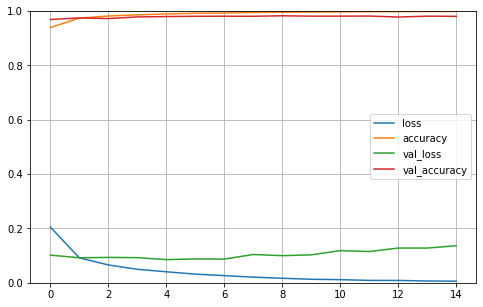

In [81]:
# Alternate code for accuracy and loss
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

## 3d. Hyperparameter Tuning

In [82]:
# changing activation function to sigmoid

model_3_a = models.Sequential()
model_3_a.add(layers.Dense(700, activation='sigmoid', input_shape=(28 * 28,)))
model_3_a.add(layers.Dense(10, activation='softmax'))   

In [83]:
# Compile the model
model_3_a.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [85]:
# Train the model
start_time = time.time()
history = model_3_a.fit(train_images, train_labels, epochs=30,
                    validation_data=(val_images, val_labels),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])
elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 8s 148us/sample - loss: 8.1124e-04 - accuracy: 0.9998 - val_loss: 0.0814 - val_accuracy: 0.9836
Epoch 2/30
55000/55000 [==============================] - 8s 147us/sample - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0794 - val_accuracy: 0.9846
Epoch 3/30
55000/55000 [==============================] - 8s 145us/sample - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0909 - val_accuracy: 0.9820
Epoch 4/30
55000/55000 [==============================] - 8s 148us/sample - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0853 - val_accuracy: 0.9826
Epoch 5/30
55000/55000 [==============================] - 8s 145us/sample - loss: 4.3569e-04 - accuracy: 1.0000 - val_loss: 0.0782 - val_accuracy: 0.9854
Epoch 6/30
55000/55000 [==============================] - 8s 150us/sample - loss: 2.6227e-04 - accuracy: 0.9999 - val_loss: 0.0778 - val_accuracy: 0.9860
Epoch 7/30
55000/55000 [===============

In [86]:
test_loss, test_acc = model_3_a.evaluate(test_images, test_labels)

In [87]:
print(f'test accuracy: {test_acc}, test loss: {test_loss}')

test accuracy: 0.9821000099182129, test loss: 0.10111340650927571


In [88]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

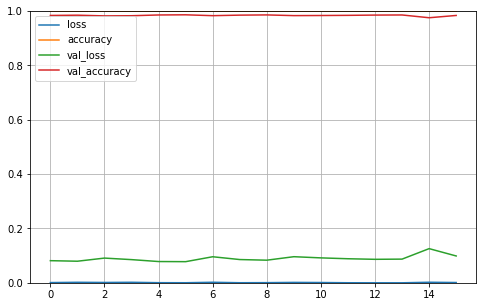

In [89]:
# Alternate code for accuracy and loss
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

## 3e. Confusion Matrix

In [90]:
# Assign predicted classes
pred_classes = model_3.predict_classes(train_images)

In [91]:
# Create confusion matrix with values
conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[5441,    0,    0,    0,    0,    0,    3,    0,    0,    0],
       [   0, 6175,    0,    0,    1,    0,    0,    2,    1,    0],
       [   0,    0, 5467,    0,    0,    0,    0,    3,    0,    0],
       [   0,    0,    0, 5637,    0,    0,    1,    0,    0,    0],
       [   0,    0,    0,    0, 5305,    0,    1,    1,    0,    0],
       [   0,    0,    0,    0,    0, 4985,    2,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 5417,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 5713,    0,    2],
       [   0,    2,    0,    1,    0,    0,    0,    1, 5385,    0],
       [   0,    0,    0,    2,    5,    0,    0,    2,    1, 5444]])

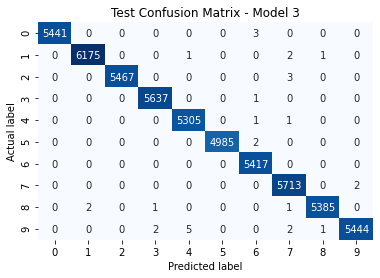

In [92]:
# Plot with values transposed to show actual versus predicted values
# m1_cm = confusion_matrix(train_labels, pred_classes)
m3_cm_plt=sns.heatmap(conf_mx, square=False, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title("Test Confusion Matrix - Model 3")
plt.show();

In [93]:
# Plot normalized confusion matrix
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

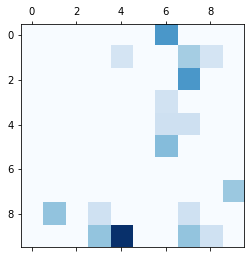

In [94]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap="Blues")
plt.show()

In [95]:
# Assign predicted classes
pred_classes = model_3_a.predict_classes(train_images)

In [96]:
# Create confusion matrix with values
conf_mx = confusion_matrix(train_labels,pred_classes)
conf_mx

array([[5444,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 6179,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 5470,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 5638,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 5307,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 4987,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 5417,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 5715,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5389,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 5454]])

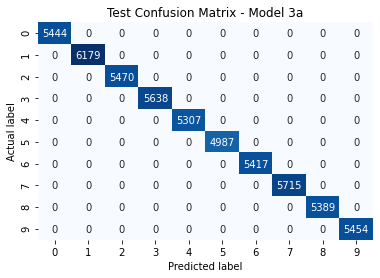

In [97]:
# Plot with values transposed to show actual versus predicted values
# m1_cm = confusion_matrix(train_labels, pred_classes)
m3_cm_plt=sns.heatmap(conf_mx, square=False, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title("Test Confusion Matrix - Model 3a")
plt.show();

In [98]:
# Plot normalized confusion matrix
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

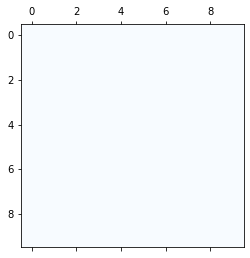

In [99]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap="Blues")
plt.show()

## 3d. Analyzing Errors

In [100]:
# Define function for plotting example digits
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = 'binary', **options)
    plt.axis("off")

ZeroDivisionError: ignored

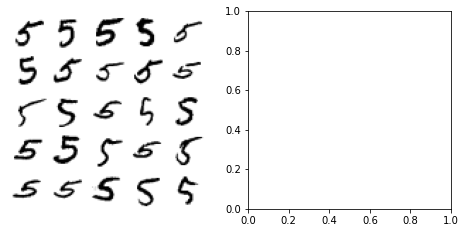

In [101]:
cl_a, cl_b = 5, 8
X_aa = train_images[(train_labels == cl_a) & (pred_classes == cl_a)]
X_ab = train_images[(train_labels == cl_a) & (pred_classes == cl_b)]
X_ba = train_images[(train_labels == cl_b) & (pred_classes == cl_a)]
X_bb = train_images[(train_labels == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# 4. Experiment 4

In [102]:
# Reduce the # of dimensions from 784 to 154 input nodes. 

# Reduce dimensions to those containing 95% of the variance in the training images
pca = PCA(n_components=0.95)
train_images_red = pca.fit_transform(train_images)
val_images_red = pca.transform(val_images)
test_images_red = pca.transform(test_images)

In [103]:
# Evaluate shape of data with reduced dimensions
test_images_red.shape, train_images_red.shape, val_images_red.shape

((10000, 154), (55000, 154), (5000, 154))

## 4a. Build, Train, and Test Model before PCA

In [104]:
# # If loading previous model:
# model = model_3()
# model_4 = load_model_3('results/mnist_model_3.h5')

model_4 = models.Sequential()
model_4.add(layers.Dense(700, activation='sigmoid', input_shape=(28 * 28,)))
model_4.add(layers.Dense(10, activation='softmax')) 

In [105]:
model_4.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 700)               549500    
_________________________________________________________________
dense_109 (Dense)            (None, 10)                7010      
Total params: 556,510
Trainable params: 556,510
Non-trainable params: 0
_________________________________________________________________


In [106]:
# Compile the model
model_4.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [107]:
# If loading previous model:
# model = model_2()
# model = load_model_3('results/keras_mnist_model_3.h5')

# Train the model
start_time = time.time()
history = model_4.fit(train_images, train_labels, epochs=30,
                    validation_data=(val_images, val_labels),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])
elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 9s 160us/sample - loss: 0.3427 - accuracy: 0.9020 - val_loss: 0.2178 - val_accuracy: 0.9358
Epoch 2/30
55000/55000 [==============================] - 9s 159us/sample - loss: 0.1787 - accuracy: 0.9475 - val_loss: 0.1341 - val_accuracy: 0.9600
Epoch 3/30
55000/55000 [==============================] - 9s 166us/sample - loss: 0.1161 - accuracy: 0.9656 - val_loss: 0.1008 - val_accuracy: 0.9686
Epoch 4/30
55000/55000 [==============================] - 9s 162us/sample - loss: 0.0805 - accuracy: 0.9759 - val_loss: 0.0842 - val_accuracy: 0.9752
Epoch 5/30
55000/55000 [==============================] - 8s 152us/sample - loss: 0.0587 - accuracy: 0.9824 - val_loss: 0.0720 - val_accuracy: 0.9786
Epoch 6/30
55000/55000 [==============================] - 8s 152us/sample - loss: 0.0437 - accuracy: 0.9868 - val_loss: 0.0654 - val_accuracy: 0.9794
Epoch 7/30
55000/55000 [===========================

In [108]:
test_loss, test_acc = model_4.evaluate(test_images, test_labels)

In [109]:
print(f'test accuracy: {test_acc}, test loss: {test_loss}')

test accuracy: 0.9807000160217285, test loss: 0.08285907910983979


## 4b. Build, train, and test the model on the new data

In [110]:
# check started code for input dimensions

model_4_pca = models.Sequential()
model_4_pca.add(layers.Dense(700, activation='sigmoid', input_shape=(154,)))
model_4_pca.add(layers.Dense(10, activation='softmax')) 

In [111]:
# For use with non-categorical labels
model_4_pca.compile(optimizer='Adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [112]:
# Train the model with the lower-dimensional data
start_time = time.time()
history = model_4_pca.fit(train_images_red, train_labels, epochs=30,
                      validation_data=(val_images_red, val_labels),
                      callbacks=[keras.callbacks.EarlyStopping(patience=10)])
elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 5s 95us/sample - loss: 0.4363 - accuracy: 0.8831 - val_loss: 0.2778 - val_accuracy: 0.9210
Epoch 2/30
55000/55000 [==============================] - 5s 84us/sample - loss: 0.2917 - accuracy: 0.9160 - val_loss: 0.2584 - val_accuracy: 0.9260
Epoch 3/30
55000/55000 [==============================] - 5s 83us/sample - loss: 0.2640 - accuracy: 0.9236 - val_loss: 0.2372 - val_accuracy: 0.9346
Epoch 4/30
55000/55000 [==============================] - 5s 84us/sample - loss: 0.2294 - accuracy: 0.9339 - val_loss: 0.2008 - val_accuracy: 0.9432
Epoch 5/30
55000/55000 [==============================] - 5s 96us/sample - loss: 0.1890 - accuracy: 0.9450 - val_loss: 0.1675 - val_accuracy: 0.9518
Epoch 6/30
55000/55000 [==============================] - 5s 86us/sample - loss: 0.1536 - accuracy: 0.9552 - val_loss: 0.1450 - val_accuracy: 0.9580
Epoch 7/30
55000/55000 [==============================] -

In [113]:
hist_dict = history.history
hist_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [114]:
print(f'''acc: {hist_dict['accuracy'][-1]:.4}, val acc: {hist_dict['val_accuracy'][-1]:.4},
loss: {hist_dict['loss'][-1]:.4}, val loss: {hist_dict['val_loss'][-1]:.4}''')

acc: 0.9999, val acc: 0.9836,
loss: 0.0006615, val loss: 0.0696


In [115]:
test_loss, test_acc = model_4_pca.evaluate(test_images_red, test_labels)

In [116]:
# Results
print(f'test acc: {test_acc}, test loss: {test_loss}')  

test acc: 0.980400025844574, test loss: 0.08521589306199039


## 4c. Compare Models

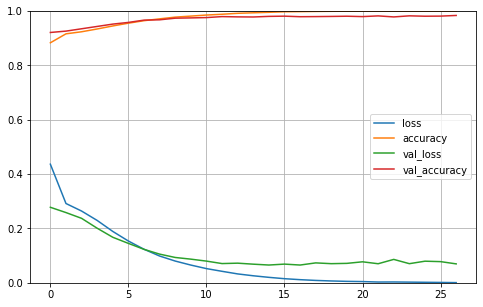

In [117]:
# Alternate code for accuracy and loss
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

## 5. Experiment 5

## 5a. Reduce Dimensionality

In [118]:
# Use RF w/100 trees to rank importance of 784 features, and pick the top 70

# Define and train model
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(train_images,train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

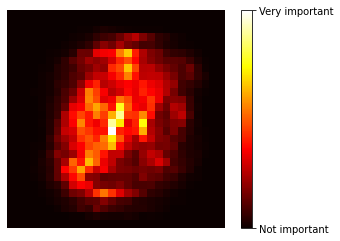

In [119]:
# https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb
import matplotlib as mpl
# import matplotlib.pyplot as plt

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

In [120]:
# Get the indices of the 70 most "important" features
# https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
n = 70
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]          # get the indices of the 70 "most important" features/pixels
len(idx)

70

In [121]:
# Create training, validation and test images using just the 70 pixel locations obtained above
train_images_sm = train_images[:,idx]
val_images_sm = val_images[:,idx]
test_images_sm = test_images[:,idx]
train_images_sm.shape, val_images.shape, test_images_sm.shape # the reduced images have dimension 70

((55000, 70), (5000, 784), (10000, 70))

In [122]:
# to convert an index n, 0<= n < 784
def pair(n,size):
    x = n//size 
    y = n%size
    return x,y

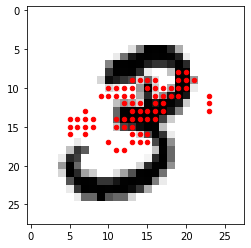

In [123]:
# Visualize features
plt.imshow(train_images[1].reshape(28,28),cmap='binary')
x, y = np.array([pair(k,28) for k in idx]).T
plt.scatter(x,y,color='red',s=20)

## 5b. Build, Train, Test Model Before RF

In [124]:
# If loading previous model:
# model = model_5()
# model_5 = load_model_5('results/mnist_model_4.h5')

model_5 = models.Sequential()
model_5.add(layers.Dense(700, activation='sigmoid', input_shape=(28 * 28,)))
model_5.add(layers.Dense(10, activation='softmax')) 

In [125]:
model_5.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 700)               549500    
_________________________________________________________________
dense_113 (Dense)            (None, 10)                7010      
Total params: 556,510
Trainable params: 556,510
Non-trainable params: 0
_________________________________________________________________


In [126]:
# For use with non-categorical labels
model_5.compile(optimizer='Adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [127]:
# If loading previous model:
# model = model_2()
# model = load_model_3('results/keras_mnist_model_3.h5')

# Train the model
start_time = time.time()
history = model_5.fit(train_images, train_labels, epochs=30,
                    validation_data=(val_images, val_labels),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])
elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 11s 209us/sample - loss: 0.3454 - accuracy: 0.9008 - val_loss: 0.2023 - val_accuracy: 0.9410
Epoch 2/30
55000/55000 [==============================] - 10s 189us/sample - loss: 0.1778 - accuracy: 0.9474 - val_loss: 0.1336 - val_accuracy: 0.9610
Epoch 3/30
55000/55000 [==============================] - 10s 188us/sample - loss: 0.1156 - accuracy: 0.9657 - val_loss: 0.0978 - val_accuracy: 0.9700
Epoch 4/30
55000/55000 [==============================] - 10s 187us/sample - loss: 0.0808 - accuracy: 0.9749 - val_loss: 0.0841 - val_accuracy: 0.9744
Epoch 5/30
55000/55000 [==============================] - 10s 185us/sample - loss: 0.0578 - accuracy: 0.9821 - val_loss: 0.0707 - val_accuracy: 0.9788
Epoch 6/30
55000/55000 [==============================] - 10s 184us/sample - loss: 0.0436 - accuracy: 0.9865 - val_loss: 0.0688 - val_accuracy: 0.9792
Epoch 7/30
55000/55000 [=====================

In [128]:
hist_dict = history.history
hist_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [129]:
print(f'''acc: {hist_dict['accuracy'][-1]:.4}, val acc: {hist_dict['val_accuracy'][-1]:.4},
loss: {hist_dict['loss'][-1]:.4}, val loss: {hist_dict['val_loss'][-1]:.4}''')

acc: 0.9993, val acc: 0.9812,
loss: 0.002639, val loss: 0.07869


In [130]:
test_loss, test_acc = model_5.evaluate(test_images, test_labels)

In [131]:
print(f'test accuracy: {test_acc}, test loss: {test_loss}')

test accuracy: 0.9818999767303467, test loss: 0.0833888368780179


## 5c. Build, Train, and Test the Model on New Data

In [132]:
model_5_rf = models.Sequential()
model_5_rf.add(layers.Dense(700, activation='relu', input_shape=(70,)))
model_5_rf.add(layers.Dense(10, activation='softmax'))  

In [133]:
# Compile the model
model_5_rf.compile(optimizer='Adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [134]:
# Train the model
start_time = time.time()
history = model_5_rf.fit(train_images_sm, train_labels, epochs=30,
                    validation_data=(val_images_sm, val_labels),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])
elapsed_time = time.time() - start_time
print('--------------------------')
print('Training time in seconds: ', round(elapsed_time,2))
print('--------------------------')

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 4s 79us/sample - loss: 0.4620 - accuracy: 0.8610 - val_loss: 0.2940 - val_accuracy: 0.9110
Epoch 2/30
55000/55000 [==============================] - 4s 68us/sample - loss: 0.2667 - accuracy: 0.9186 - val_loss: 0.2357 - val_accuracy: 0.9266
Epoch 3/30
55000/55000 [==============================] - 4s 70us/sample - loss: 0.2158 - accuracy: 0.9323 - val_loss: 0.2108 - val_accuracy: 0.9356
Epoch 4/30
55000/55000 [==============================] - 4s 67us/sample - loss: 0.1865 - accuracy: 0.9419 - val_loss: 0.1877 - val_accuracy: 0.9446
Epoch 5/30
55000/55000 [==============================] - 4s 69us/sample - loss: 0.1644 - accuracy: 0.9483 - val_loss: 0.1836 - val_accuracy: 0.9436
Epoch 6/30
55000/55000 [==============================] - 4s 69us/sample - loss: 0.1500 - accuracy: 0.9523 - val_loss: 0.1809 - val_accuracy: 0.9458
Epoch 7/30
55000/55000 [==============================] -

In [135]:
hist_dict = history.history
hist_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [136]:
print(f'''acc: {hist_dict['accuracy'][-1]:.4}, val acc: {hist_dict['val_accuracy'][-1]:.4},
loss: {hist_dict['loss'][-1]:.4}, val loss: {hist_dict['val_loss'][-1]:.4}''')

acc: 0.9849, val acc: 0.9528,
loss: 0.0474, val loss: 0.1953


In [137]:
test_loss, test_acc = model_5_rf.evaluate(test_images_sm, test_labels)

In [138]:
print(f'test accuracy: {test_acc}, test loss: {test_loss}')

test accuracy: 0.9459999799728394, test loss: 0.1997801076138625


## 5e. Compare Model 3-5

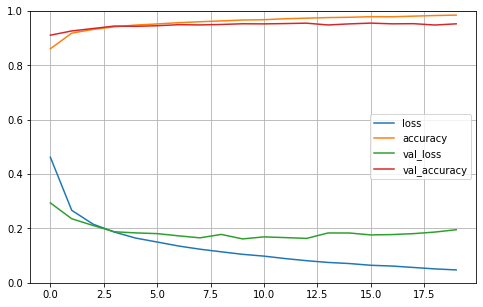

In [139]:
# Alternate code for accuracy and loss
# Plot learning curves for model
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()